Batches: 100%|██████████| 10/10 [00:00<00:00, 16.39it/s]
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py

Best Params LR: {'C': 0.1, 'penalty': 'l2'}
Best Params RF: {'max_depth': None, 'n_estimators': 200}
Best Params XGB: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmu

Cross-validation Accuracy: 0.7661 ± 0.0585


/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:15:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/linear_model/

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        53
           1       0.67      0.35      0.46        23

    accuracy                           0.75        76
   macro avg       0.72      0.64      0.65        76
weighted avg       0.74      0.75      0.72        76



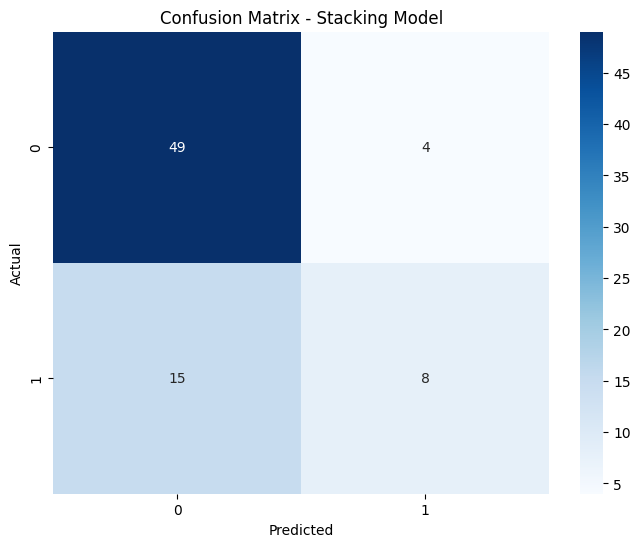

Modelo salvo como 'stacking_model.pkl'


In [3]:
import pandas as pd
import numpy as np
import joblib

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregar dados
df = pd.read_csv('mde-2025-1-enem-text-classification/train.csv')

# 2. Engenharia de texto
def construir_texto(row, peso_enunciado=2):
    enunciado = (str(row['ENUNCIADO_QUESTAO']) + ' ') * peso_enunciado
    alternativas = ' '.join([str(row['ALTERNATIVA_A']), str(row['ALTERNATIVA_B']), str(row['ALTERNATIVA_C']), str(row['ALTERNATIVA_D']), str(row['ALTERNATIVA_E'])])
    return enunciado + alternativas

df['TEXTO_FINAL'] = df.apply(construir_texto, axis=1)

# 3. Embeddings com Sentence-BERT
model_bert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X_embeddings = model_bert.encode(df['TEXTO_FINAL'].tolist(), show_progress_bar=True)

y = df['LABEL_QUESTAO']

# 4. Separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.25, stratify=y, random_state=42)

# 5. Modelos base
lr = LogisticRegression(max_iter=500, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 6. Grid Search para tunar os modelos
param_grid_lr = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l2']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6]
}

# Aplicar GridSearchCV
grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=1)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=1)
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=1)

grid_lr.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)

print("Best Params LR:", grid_lr.best_params_)
print("Best Params RF:", grid_rf.best_params_)
print("Best Params XGB:", grid_xgb.best_params_)

# Modelos otimizados
modelo_lr = grid_lr.best_estimator_
modelo_rf = grid_rf.best_estimator_
modelo_xgb = grid_xgb.best_estimator_

# 7. Stacking Classifier
stack_model = StackingClassifier(
    estimators=[
        ('lr', modelo_lr),
        ('rf', modelo_rf),
        ('xgb', modelo_xgb)
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=1,
    passthrough=True
)


# 8. Treinar Stacking com validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(stack_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-validation Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

# 9. Treinar no conjunto completo
stack_model.fit(X_train, y_train)

# 10. Avaliação
y_pred = stack_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking Model')
plt.show()

# 11. Salvar modelo
modelo_completo = {
    'model': stack_model,
    'bert_model': model_bert
}

joblib.dump(modelo_completo, 'model/stacking_model.pkl')

print("Modelo salvo como 'stacking_model.pkl'")

In [5]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Carregar modelo salvo
modelo_completo = joblib.load('model/stacking_model.pkl')
model = modelo_completo['model']
bert_model = modelo_completo['bert_model']

# 2. Carregar dados de teste (com rótulos verdadeiros)
df_test = pd.read_csv('mde-2025-1-enem-text-classification/test.csv')

# 3. Engenharia de texto
def construir_texto(row, peso_enunciado=2):
    enunciado = (str(row['ENUNCIADO_QUESTAO']) + ' ') * peso_enunciado
    alternativas = ' '.join([
        str(row['ALTERNATIVA_A']), 
        str(row['ALTERNATIVA_B']), 
        str(row['ALTERNATIVA_C']), 
        str(row['ALTERNATIVA_D']), 
        str(row['ALTERNATIVA_E'])
    ])
    return enunciado + alternativas

df_test['TEXTO_FINAL'] = df_test.apply(construir_texto, axis=1)

# 4. Embeddings do texto de teste
X_test_vec = bert_model.encode(df_test['TEXTO_FINAL'].tolist(), show_progress_bar=True)

# 5. Fazer previsões
predicoes = model.predict(X_test_vec)

# --- GERAR TABELA DE ACURÁCIA ---
# Checar se o rótulo real existe
if 'label' in df_test.columns:
    y_true = df_test['label']  # rótulo verdadeiro
    y_pred = predicoes         # rótulo previsto

    # 5.1. Acurácia
    acuracia = accuracy_score(y_true, y_pred)
    print(f"Acurácia: {acuracia:.4f}")

    # 5.2. Matriz de confusão
    matriz_confusao = confusion_matrix(y_true, y_pred)
    print("\nMatriz de Confusão:")
    print(matriz_confusao)

    # 5.3. Relatório de classificação
    relatorio = classification_report(y_true, y_pred)
    print("\nRelatório de Classificação:")
    print(relatorio)
else:
    print("O conjunto de teste não possui a coluna 'label' para calcular a acurácia.")

# 6. Criar submissão
df_submissao = pd.DataFrame({
    'id': df_test['ID_QUESTAO'],
    'label': predicoes
})

df_submissao.to_csv('submissao.csv', index=False)

print("\nArquivo de submissão 'submissao.csv' gerado com sucesso!")


Batches: 100%|██████████| 4/4 [00:00<00:00, 19.32it/s]

O conjunto de teste não possui a coluna 'label' para calcular a acurácia.

Arquivo de submissão 'submissao.csv' gerado com sucesso!



/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/lucasaraujo/Documents/UFRPE/Mineração de Dados Educacionais 2025.1/Comp_1_kaggle/.venv/lib/python3.12/site-pa